In [1]:
import bluepysnap
from pathlib import Path
from matplotlib import pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import pandas as pd
import numpy as np
import h5py 

In [4]:
col_cons = '#E71D76'
col_prod ='#3172B8'
color_ndam = '#544B3D'
color_met = '#FFA400'
c_pal = 'bwr'
color_layer= {1:'#1BE7FF',2:'#60992D',3: '#FED766',4: '#D76A03', 5: '#922D50',6: '#B0A3D4'}

In [6]:
def read_result(result_path):
    read_result = h5py.File(result_path)
    result = read_result['report']['All']['data']

    return(result)

def mapping_extract(result_path):
    """
    map the neurons and ids
    """
    read_result = h5py.File(result_path)
    result = read_result['report']['All']['data']
        
    extract_mapping = read_result['report']['All']['mapping']['node_ids'][:]
    
    t0 = read_result['report']['All']['mapping']['time'][0]
    T =read_result['report']['All']['mapping']['time'][1]
    dt = read_result['report']['All']['mapping']['time'][2]

    
    N= (T-t0)/dt
    time_line = np.linspace(t0,T, int(N))
    N2 = (T-t0)/0.025
    voltage_time_line = np.linspace(t0,T,int(N2))
    return(extract_mapping, time_line, voltage_time_line)

In [7]:
# read the circuit from ../config/circuit_config.json
# NOTE: in circuit_config.json many path are relative
# We need to read the circuit to get the info about the neurons as e-type and layer
#circuit = bluepysnap.Circuit('/gpfs/bbp.cscs.ch/data/project/proj137/farinaNGV/Paper_results/config/circuit_config.json')
circuit = bluepysnap.Circuit('../config/circuit_config.json')
node_population = circuit.nodes["All"]
print('Nodes in the circuit', len(node_population.get().index.to_list()))
pandas_nodes = node_population.get()

Nodes in the circuit 129348


In [8]:
# Path: Results Folder can be downloaded from 10.5281/zenodo.14187063
results_path = '/gpfs/bbp.cscs.ch/data/project/proj137/farinaNGV/Paper_results/my_simulation/'

In [9]:
# Metabolism
sim_results_path = results_path + 'reporting_metabolism_young/'

voltage_met = read_result(sim_results_path + 'ndam_v.h5')
Nai_met = read_result(sim_results_path+  'ndam_nai.h5')
metab_nai = read_result(sim_results_path+  'metab_nai.h5')
Ki_met = read_result(sim_results_path+ 'ndam_ki.h5')
ATP_met = read_result(sim_results_path+  'ndam_atpi.h5')
ADP_met = read_result(sim_results_path+ 'ndam_adpi.h5')
cai_met = read_result(sim_results_path+ 'ndam_cai.h5')
cli_met = read_result(sim_results_path+ 'ndam_cli.h5')
after_ATP_met = read_result(sim_results_path+ 'metab_atpi_after_sync.h5')
before_ATP_met = read_result(sim_results_path+ 'metab_atpi_before_sync.h5')

mapping_met,time_line_met, volt_time_met = mapping_extract(sim_results_path+ 'ndam_nai.h5')

In [10]:
# Creating Empty DataFrame and Storing it in variable df
df = pd.DataFrame()
df['ids'] = mapping_met
df['etype'] = [pandas_nodes['etype'][i] for i in df['ids']]
df['layer'] = [pandas_nodes['layer'][i] for i in df['ids']]
df['synapse_class'] = [ pandas_nodes['synapse_class'][i] for i in df['ids']]
# Data Folder can be downloaded from 10.5281/zenodo.14187063
#  Obtain with python code Compute_ATP_mol_per_AP.py
df_mol= pd.read_csv('./Data/Fig3BC_Molecules_ATPi_AP_metabolism.csv') 
# Data Folder can be downloaded from 10.5281/zenodo.14187063
# Obtain with python code Compute_ATP_mol_per_resting_potential.py
df_mol['ATPmolXrest']= pd.read_csv('./Data/Fig3BC_Molecules_ATPi_resting_state_metabolism.csv')['ATPmolXresting'] 
df_combined= pd.merge(df_mol, df[['ids', 'layer']], on='ids', how='left')

In [11]:
# Data Folder can be downloaded from 10.5281/zenodo.14187063
nodes_ids = np.load('./Data/spiking_nodes_met.npy')
idx = nodes_ids[1]
print(idx)

68489


In [12]:
t_start = 2001
t_end = 2100
a = 1.0  # Transparency

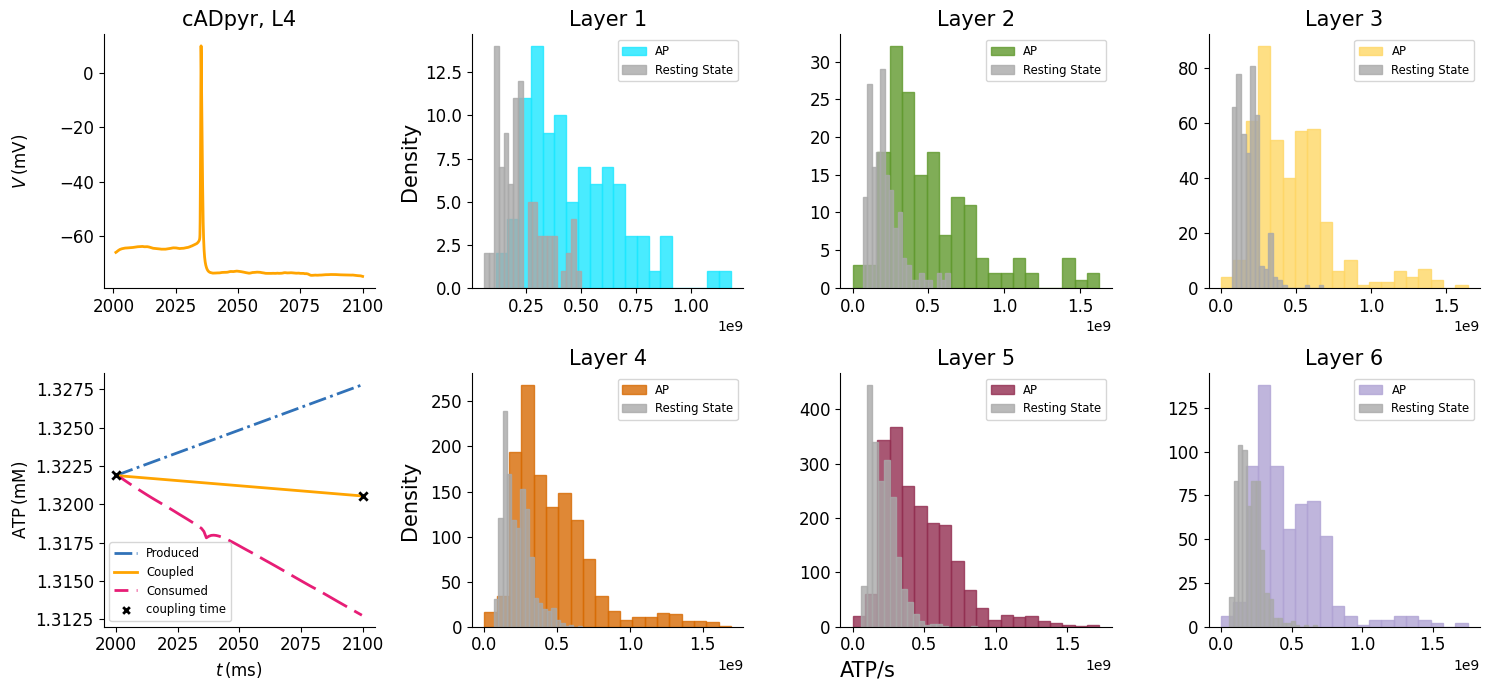

In [13]:
fig, axs = plt.subplot_mosaic(
    [
        ["voltage", "layer1", "layer2", "layer3"],
        ["ATP", "layer4", "layer5", "layer6"]
    ],
    figsize=(15, 7),
    sharex=False, sharey=False
)

# Set the tick label size
tick_label_size = 12

# Plot for the voltage subplot (first row, first column)
ind_c = np.where(mapping_met == idx)[0]
axs["voltage"].plot(volt_time_met[int(t_start/0.025):int(t_end/0.025)], voltage_met[int(t_start/0.025):int(t_end/0.025), ind_c], linewidth=2, alpha=a, c=color_met)
axs["voltage"].set_ylabel("$V\, (\mathrm{mV})$", fontsize=12)
axs["voltage"].spines[['right', 'top']].set_visible(False)
axs["voltage"].tick_params(axis='both', labelsize=tick_label_size)

# Plot for the ATP subplot (second row, first column)
time_met_after = np.arange(0, 3100, 100)
axs["ATP"].plot(time_met_after[20:22], [after_ATP_met[20, ind_c], before_ATP_met[22, ind_c]], linewidth=2, alpha=a, c=col_prod, linestyle='-.', label='Produced')
axs["ATP"].plot(time_met_after[20:22], after_ATP_met[20:22, ind_c], linewidth=2, alpha=a, c=color_met, label='Coupled')
axs["ATP"].plot(time_line_met[t_start:t_end], ATP_met[t_start:t_end, ind_c], linewidth=2, c=col_cons,linestyle=(5, (10, 3)), label='Consumed')
axs["ATP"].scatter(time_met_after[20], after_ATP_met[20, ind_c], marker='x', linewidth=2, c='k', label='coupling time', zorder=3)
axs["ATP"].scatter(time_met_after[21], after_ATP_met[21, ind_c], marker='x', linewidth=2, c='k', zorder=3)
axs["ATP"].set_ylabel("$\mathrm{ATP}\, (\mathrm{mM})$", fontsize=12)
axs["ATP"].set_xlabel("$t\, (\mathrm{ms})$", fontsize=12)
axs["ATP"].spines[['right', 'top']].set_visible(False)
axs["ATP"].tick_params(axis='both', labelsize=tick_label_size)
axs["ATP"].legend(loc='best', fontsize='small', markerscale=0.8)

# Set titles for neuron properties
cell_id = node_population.get(idx)
axs["voltage"].set_title(f"{cell_id.get('etype')}, L{cell_id.get('layer')}", fontsize=15)

# Plot histograms for each layer with individual legends
unique_layers = np.sort(df_combined['layer'].unique())
for ax_key, layer in zip(["layer1", "layer2", "layer3", "layer4", "layer5", "layer6"], unique_layers):
    layer_data = df_combined[df_combined['layer'] == layer]['ATPmolXAP']
    layer_data_rest = df_combined[df_combined['layer'] == layer]['ATPmolXrest']
    
    axs[ax_key].hist(layer_data, bins=20, alpha=0.8, color=color_layer[layer], edgecolor=color_layer[layer], label='AP')
    axs[ax_key].hist(layer_data_rest, bins=20, alpha=0.8, color='darkgrey', edgecolor='darkgrey', label='Resting State')
    axs[ax_key].set_title(f"Layer {layer}", fontsize=15)
    axs[ax_key].spines[['top', 'right']].set_visible(False)
    axs[ax_key].tick_params(axis='both', labelsize=tick_label_size)
    axs[ax_key].legend(loc='best', fontsize='small', markerscale=0.8)  # Add legend to each plot
# just align the last column of Axes:
fig.align_ylabels(axs["voltage"])

# Set labels for density and ATP/s
axs["layer1"].set_ylabel('Density', fontsize=15)
axs["layer4"].set_ylabel('Density', fontsize=15)
axs["layer5"].set_xlabel('ATP/s', loc='left', fontsize=15)
 
fig.align_ylabels()
fig.tight_layout()
#plt.savefig("./RESULTS/Figure3bc.pdf", format="pdf", bbox_inches='tight')

In [14]:
# Initialize a dictionary to store statistics for each layer
statistics = {}

for layer in unique_layers:
    # Extract data for the current layer
    layer_data = df_combined[df_combined['layer'] == layer]['ATPmolXAP']
    layer_data_rest = df_combined[df_combined['layer'] == layer]['ATPmolXrest']
    
    # Compute statistics
    stats = {
        "AP_mean": layer_data.mean(),
        "AP_std": layer_data.std(),
        "AP_median": layer_data.median(),
        #"AP_IQR": layer_data.quantile(0.75) - layer_data.quantile(0.25),
        "Rest_mean": layer_data_rest.mean(),
        "Rest_std": layer_data_rest.std(),
        "Rest_median": layer_data_rest.median(),
        #"Rest_IQR": layer_data_rest.quantile(0.75) - layer_data_rest.quantile(0.25),
    }
    
    # Perform a t-test between AP and Resting State data
    from scipy.stats import ttest_ind
    stats["T-test_pval"] = ttest_ind(layer_data, layer_data_rest, equal_var=False).pvalue
    
    # Store stats in the dictionary
    statistics[f"Layer {layer}"] = stats

# Convert dictionary to a pandas DataFrame for easy viewing
stats_df = pd.DataFrame(statistics).T
print(stats_df)


              AP_mean        AP_std    AP_median     Rest_mean      Rest_std  \
Layer 1  4.643739e+08  2.160428e+08  409641280.0  2.237998e+08  1.047327e+08   
Layer 2  5.095594e+08  3.155818e+08  412724000.0  2.127020e+08  1.106722e+08   
Layer 3  4.748885e+08  2.681492e+08  414526440.0  1.803789e+08  7.704214e+07   
Layer 4  4.668554e+08  2.688760e+08  394964220.0  2.250039e+08  9.534172e+07   
Layer 5  4.657601e+08  2.568784e+08  406646750.0  2.113404e+08  9.208788e+07   
Layer 6  4.770378e+08  2.622527e+08  415802020.0  2.018960e+08  8.258229e+07   

         Rest_median    T-test_pval  
Layer 1  203517440.0   4.651904e-17  
Layer 2  194798470.0   9.529267e-24  
Layer 3  170087815.0   2.519979e-76  
Layer 4  207253940.0  4.587303e-160  
Layer 5  197118750.0  5.207562e-284  
Layer 6  188432690.0  5.160619e-103  


In [15]:
# Add necessary imports
import pandas as pd

# Convert the DataFrame to a LaTeX table
latex_table = stats_df.to_latex(
    float_format="%.2e",  # Format float numbers in scientific notation
    index=True,           # Include the index (Layer names)
    column_format="lcccccccccc",  # Specify alignment for each column
    caption="Statistical Analysis of ATP Consumption in Neuronal Layers.",
    label="tab:atp_stats"
)

# Print the LaTeX table
print(latex_table)

\begin{table}
\caption{Statistical Analysis of ATP Consumption in Neuronal Layers.}
\label{tab:atp_stats}
\begin{tabular}{lcccccccccc}
\toprule
 & AP_mean & AP_std & AP_median & Rest_mean & Rest_std & Rest_median & T-test_pval \\
\midrule
Layer 1 & 4.64e+08 & 2.16e+08 & 4.10e+08 & 2.24e+08 & 1.05e+08 & 2.04e+08 & 4.65e-17 \\
Layer 2 & 5.10e+08 & 3.16e+08 & 4.13e+08 & 2.13e+08 & 1.11e+08 & 1.95e+08 & 9.53e-24 \\
Layer 3 & 4.75e+08 & 2.68e+08 & 4.15e+08 & 1.80e+08 & 7.70e+07 & 1.70e+08 & 2.52e-76 \\
Layer 4 & 4.67e+08 & 2.69e+08 & 3.95e+08 & 2.25e+08 & 9.53e+07 & 2.07e+08 & 4.59e-160 \\
Layer 5 & 4.66e+08 & 2.57e+08 & 4.07e+08 & 2.11e+08 & 9.21e+07 & 1.97e+08 & 5.21e-284 \\
Layer 6 & 4.77e+08 & 2.62e+08 & 4.16e+08 & 2.02e+08 & 8.26e+07 & 1.88e+08 & 5.16e-103 \\
\bottomrule
\end{tabular}
\end{table}

